In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [205]:
df = pd.read_csv('../Data/Election_2018_NA_Results_Raw.csv')
dfResultsOnly = pd.read_csv('../Data/Election_2018_NA_Results_VotingOnly.csv')
# Some manual participation corrections
df.loc[df['seat'] == 'NA-254','femaleTurnout'] = 0.2892992355
df.loc[df['seat'] == 'NA-125','femaleTurnout'] = np.nan
df.loc[df['seat'] == 'NA-125','maleTurnout'] = np.nan

# Exploratory Analysis

### Cumulative Votes by Party

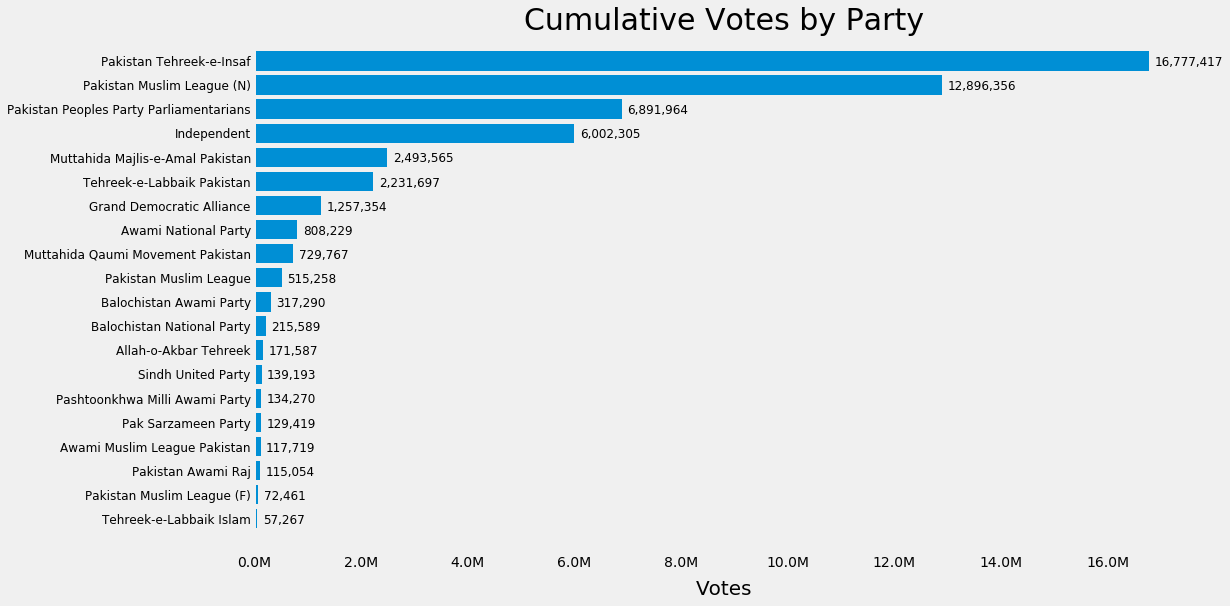

In [206]:
cumsumResultsByParty = dfResultsOnly.groupby('candidateParty')['candidateVotes'].sum().sort_values(ascending=False).reset_index().head(20)

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.tight_layout()

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize=(15,9))
ax.barh(np.arange(20),
        cumsumResultsByParty['candidateVotes'], 
        align='center')

ax.set_yticks(np.arange(20))
ax.set_yticklabels(cumsumResultsByParty['candidateParty'],fontdict={'fontsize' : 12,'horizontalalignment':'right'})
ax.invert_yaxis()  # labels read top-to-bottom
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Votes',fontdict={'fontsize' : 20},labelpad=10)
ax.set_title('Cumulative Votes by Party',fontdict={'fontsize' : 30,'verticalalignment' : 'center'})
ax.grid(b=None)

for i, v in enumerate(cumsumResultsByParty['candidateVotes']):
    ax.text(v + 100000, i + .20, "{:,}".format(v) ,fontdict={'fontsize':12})
    
fig.savefig('CumVotesByParty.png',bbox_inches='tight')

## Winners & Runner Ups

In [207]:
# Adding margins from winners.

seat = ''
for row in dfResultsOnly.iterrows():
    if row[1]['seat'] == seat:
        margin = winnerVotes - row[1]['candidateVotes']
    else:
        winnerVotes = dfResultsOnly[dfResultsOnly['seat'] == row[1]['seat']][['candidateVotes']].max().values[0]
        margin = winnerVotes - row[1]['candidateVotes']
        seat = row[1]['seat']

    dfResultsOnly.loc[row[0],'marginFromWinner'] = int(margin)

#### Winners & Runner Ups

In [208]:
winnerIdx = dfResultsOnly.groupby(by='seat',)[['candidateVotes']].idxmax()
winnerResults = dfResultsOnly.iloc[winnerIdx['candidateVotes'].values]
winnerResults = winnerResults.drop('marginFromWinner',axis=1)
runnerUpIdx = dfResultsOnly.groupby(by='seat')['candidateVotes'].nlargest(2).reset_index().groupby('seat').last()['level_1'].values
runnerupResults = dfResultsOnly.iloc[runnerUpIdx]
winnerResults = winnerResults.merge(runnerupResults[['seat','marginFromWinner']],on='seat').rename(columns={'marginFromWinner' : 'winMargin'})

In [209]:
# Winners
winnerResults.candidateParty.value_counts()

Pakistan Tehreek-e-Insaf                   116
Pakistan Muslim League (N)                  64
Pakistan Peoples Party Parliamentarians     43
Independent                                 13
Muttahida Majlis-e-Amal Pakistan            12
Muttahida Qaumi Movement Pakistan            6
Pakistan Muslim League                       4
Balochistan Awami Party                      4
Balochistan National Party                   3
Grand Democratic Alliance                    2
Jamhoori Wattan Party                        1
Awami Muslim League Pakistan                 1
Awami National Party                         1
Name: candidateParty, dtype: int64

In [210]:
# Runnerups
runnerupResults.candidateParty.value_counts()

Pakistan Tehreek-e-Insaf                   88
Pakistan Muslim League (N)                 59
Independent                                30
Muttahida Majlis-e-Amal Pakistan           26
Pakistan Peoples Party Parliamentarians    18
Grand Democratic Alliance                  16
Muttahida Qaumi Movement Pakistan           8
Awami National Party                        8
Balochistan National Party                  3
Tehreek-e-Labbaik Pakistan                  3
Balochistan National Party (Awami)          2
Sindh United Party                          2
Balochistan Awami Party                     2
Pashtoonkhwa Milli Awami Party              2
Pakistan Awami Raj                          1
Pakistan Rah-e-Haq Party                    1
Pakistan Muslim League (F)                  1
Name: candidateParty, dtype: int64

### Looking at the Margins

In [214]:
# Add ratio of winning margin to valid votes.
winnerResults['winMarginValidVotePct'] = winnerResults.seat.map(lambda x:\
                                                                winnerResults[winnerResults['seat'] == x]['winMargin'].values[0]\
                                                                / \
                                                                df[df['seat'] == x]['validVotes'].values[0] )

C:\Users\Saifi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


#### 10 closest contests

In [212]:
closest_10 = winnerResults.sort_values(by='winMarginValidVotePct').head(10)[['seat','seatName','candidateName','candidateParty','winMargin','winMarginValidVotePct']]
closest_10['winMarginValidVotePct'] =  closest_10['winMarginValidVotePct'].map(lambda x : x * 100)
closest_10

,seat,seatName,candidateName,candidateParty,winMargin,winMarginValidVotePct
122,NA-21,Mardan-II,Amir Haider Azam Khan,Awami National Party,33.0,0.017666
45,NA-140,Kasur-IV,SARDAR TALIB HASSAN NAKAI,Pakistan Tehreek-e-Insaf,236.0,0.083694
261,NA-91,Sargodha-IV,Zulfiqar Ali Bhatti,Pakistan Muslim League (N),279.0,0.105061
100,NA-190,Dera Ghazi Khan-II,MUHAMMAD AMJAD FAROOQ KHAN KHOSA,Independent,195.0,0.123577
154,NA-239,Korangi Karachi-I,MUHAMMAD AKRAM,Pakistan Tehreek-e-Insaf,336.0,0.152080
16,NA-114,Jhang-I,SAHIBZADA MUHAMMAD MEHBOOB SULTAN,Pakistan Tehreek-e-Insaf,589.0,0.199831
258,NA-89,Sargodha-II,Mohsin Nawaz Ranjha,Pakistan Muslim League (N),823.0,0.323288
128,NA-215,Sanghar-I,Naveed Dero,Pakistan Peoples Party Parliamentarians,585.0,0.355669
35,NA-131,Lahore-IX,Imran Ahmed Khan Niazi,Pakistan Tehreek-e-Insaf,680.0,0.360339
2,NA-100,Chiniot-II,QAISER AHMED SHEIKH,Pakistan Muslim League (N),856.0,0.395405


#### 10 least competitive seats

In [13]:
farthest_10 = winnerResults.sort_values(by='winMarginValidVotePct',ascending=False).head(10)[['seat','seatName','candidateName','candidateParty','winMargin','winMarginValidVotePct']]
farthest_10['winMarginValidVotePct'] =  farthest_10['winMarginValidVotePct'].map(lambda x : x * 100)
farthest_10

,seat,seatName,candidateName,candidateParty,winMargin,winMarginValidVotePct
208,NA-42,Tribal Area - III,Sajid Khan,Pakistan Tehreek-e-Insaf,1641.0,inf
146,NA-231,Sujawal,Syed Ayaz Ali Shah Serazi,Pakistan Peoples Party Parliamentarians,118803.0,77.738444
147,NA-232,Thatta,Shams un Nisa,Pakistan Peoples Party Parliamentarians,133791.0,73.316565
115,NA-203,Kamber Shahdadkot-II,Mir Amer Ali Khan Magsi,Pakistan Peoples Party Parliamentarians,67044.0,63.653194
265,NA-95,Mianwali-I,Imran Ahmed Khan Niazi,Pakistan Tehreek-e-Insaf,113523.0,46.393674
195,NA-30,Peshawar-IV,Sher Ali Arbab,Pakistan Tehreek-e-Insaf,55670.0,45.477568
159,NA-243,Karachi East-II,Imran Ahmed Khan Niazi,Pakistan Tehreek-e-Insaf,67276.0,41.269062
266,NA-96,Mianwali-II,AMJID ALI KHAN,Pakistan Tehreek-e-Insaf,102513.0,40.252795
130,NA-217,Sanghar-III,Roshanuddin Junejo,Pakistan Peoples Party Parliamentarians,59461.0,37.409325
151,NA-236,Malir-I,JAM ABDUL KARIM BIJAR,Pakistan Peoples Party Parliamentarians,40167.0,34.788973


#### 5 biggest parties that did not win an NA seat

In [203]:
votesPerSeat = dfResultsOnly.groupby('candidateParty',as_index=False)['candidateVotes'].sum()
seatPerParty = winnerResults.groupby('candidateParty').count()['seat']
votesPerSeatbyParty = votesPerSeat.join(seatPerParty,on='candidateParty')
votesPerSeatbyParty.fillna(0,inplace=True)
votesPerSeatbyParty[votesPerSeatbyParty['seat'] <= 0].sort_values(['seat','candidateVotes'],ascending=False).head(5)

,candidateParty,candidateVotes,seat
84,Tehreek-e-Labbaik Pakistan,2231697,0.0
6,Allah-o-Akbar Tehreek,171587,0.0
78,Sindh United Party,139193,0.0
73,Pashtoonkhwa Milli Awami Party,134270,0.0
38,Pak Sarzameen Party,129419,0.0


### The TLP effect

#### On seats where PML-N came second

In [221]:
tlpVotes = dfResultsOnly[dfResultsOnly['candidateParty'] == 'Tehreek-e-Labbaik Pakistan']
pmlN_tlp = runnerupResults[runnerupResults['candidateParty'] == 'Pakistan Muslim League (N)'].merge(tlpVotes,on='seat')
pmlN_tlp[pmlN_tlp['marginFromWinner_x'] < pmlN_tlp['candidateVotes_y']][['seat','seatName_x','marginFromWinner_x','candidateVotes_y']].rename(columns={'candidateVotes_y' : 'TLP_Votes'}).sort_values('marginFromWinner_x',ascending=True)

,seat,seatName_x,marginFromWinner_x,TLP_Votes
13,NA-140,Kasur-IV,236.0,15500
11,NA-131,Lahore-IX,680.0,9780
31,NA-249,Karachi West-II,718.0,23981
2,NA-108,Faisalabad-VIII,1211.0,8075
9,NA-13,Mansehra-I,1454.0,4731
6,NA-118,Nankana Sahib-II,2405.0,49345
8,NA-126,Lahore-IV,3057.0,16368
17,NA-159,Multan-VI,3232.0,6033
24,NA-172,Bahawalpur-III,4412.0,9180
4,NA-110,Faisalabad-X,6043.0,10782


Parties that won seats in these constituencies

In [225]:
winnerResults.merge(pmlN_tlp[pmlN_tlp['marginFromWinner_x'] < pmlN_tlp['candidateVotes_y']][['seat','seatName_x','marginFromWinner_x','candidateVotes_y']].rename(columns={'candidateVotes_y' : 'TLP_Votes'}).sort_values('marginFromWinner_x',ascending=True),on='seat')['candidateParty'].value_counts()

Pakistan Tehreek-e-Insaf    14
Pakistan Muslim League       2
Independent                  1
Name: candidateParty, dtype: int64

#### On seats where PTI came second

In [223]:
PTI_tlp = runnerupResults[runnerupResults['candidateParty'] == 'Pakistan Tehreek-e-Insaf'].merge(tlpVotes,on='seat')
PTI_tlp[PTI_tlp['marginFromWinner_x'] < PTI_tlp['candidateVotes_y']][['seat','seatName_x','marginFromWinner_x','candidateVotes_y']].rename(columns={'candidateVotes_y' : 'TLP_Votes'}).sort_values('marginFromWinner_x',ascending=True)

,seat,seatName_x,marginFromWinner_x,TLP_Votes
38,NA-190,Dera Ghazi Khan-II,195.0,6343
0,NA-100,Chiniot-II,856.0,6593
43,NA-248,Karachi West-I,1023.0,13797
51,NA-73,Sialkot-II,1493.0,9953
29,NA-151,Khanewal-II,1678.0,8973
3,NA-106,Faisalabad-VI,2520.0,9986
52,NA-74,Sialkot-III,3501.0,34295
49,NA-71,Gujrat-IV,7050.0,29527
40,NA-226,Hyderabad-II,7974.0,10222
14,NA-129,Lahore-VII,8142.0,12875


Parties that won seats in these constituencies

In [227]:
winnerResults.merge(PTI_tlp[PTI_tlp['marginFromWinner_x'] < PTI_tlp['candidateVotes_y']][['seat','seatName_x','marginFromWinner_x','candidateVotes_y']].rename(columns={'candidateVotes_y' : 'TLP_Votes'}).sort_values('marginFromWinner_x',ascending=True),on='seat')['candidateParty'].value_counts()

Pakistan Muslim League (N)                 12
Muttahida Qaumi Movement Pakistan           5
Independent                                 2
Pakistan Peoples Party Parliamentarians     1
Name: candidateParty, dtype: int64

## Male & Female Turnout

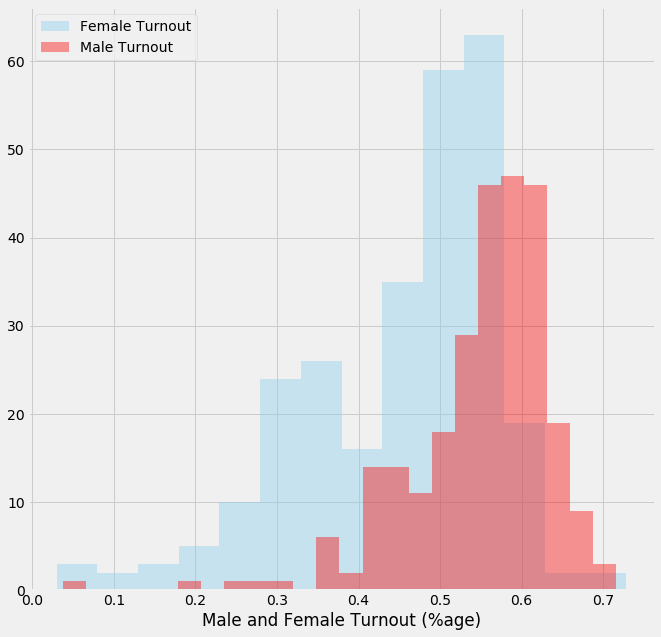

In [112]:
plt.figure(figsize=(10,10))
sns.distplot(df.dropna()['femaleTurnout'],color='skyblue',kde=False,label='Female Turnout')
sns.distplot(df.dropna()['maleTurnout'],color='red',kde=False, label='Male Turnout',axlabel='Male and Female Turnout (%age)')
plt.legend()

Female Turnout :
 count    269.000000
mean       0.454083
std        0.121525
min        0.030000
25%        0.370300
50%        0.486300
75%        0.542700
max        0.728300
Name: femaleTurnout, dtype: float64

Male Turnout :
 count    269.000000
mean       0.550963
std        0.086023
min        0.037600
25%        0.515700
50%        0.569900
75%        0.608900
max        0.715700
Name: maleTurnout, dtype: float64


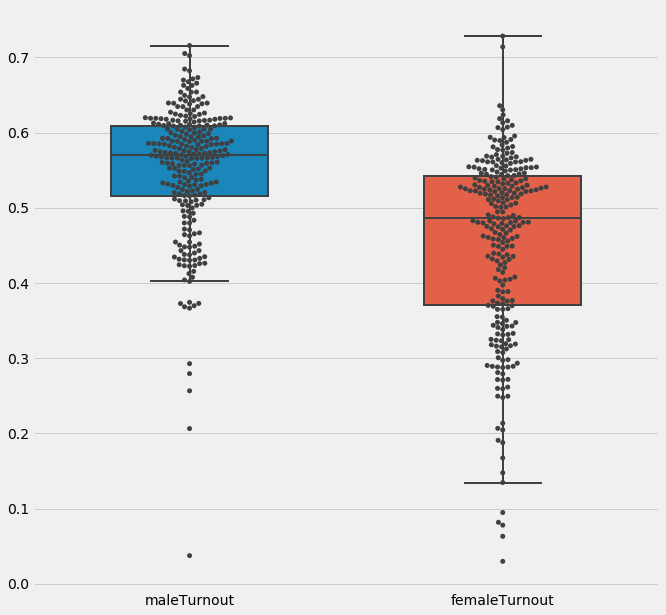

In [184]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df[['maleTurnout','femaleTurnout']],orient='v',width=0.5,showfliers=False,linewidth=2)
sns.swarmplot(data=df[['maleTurnout','femaleTurnout']], color=".25")
print('Female Turnout :\n',df['femaleTurnout'].describe())
print('\nMale Turnout :\n',df['maleTurnout'].describe())

Lowest Male Turnout

In [168]:
df.sort_values('maleTurnout',ascending=True).head(10)[['seat','seatName','registeredVoters','maleTurnout']]

,seat,seatName,registeredVoters,maleTurnout
38,NA-39,Dera Ismail Khan-II,328428,0.0376
265,NA-268,Chagai-cum-Nushki-cum-Kharan,234291,0.2065
48,NA-49,Tribal Area - X,178293,0.2567
41,NA-42,Tribal Area - III,29855,0.2795
47,NA-48,Tribal Area - IX,274205,0.2928
268,NA-271,Kech,222631,0.3666
200,NA-203,Kamber Shahdadkot-II,313641,0.3684
32,NA-33,Hangu,275947,0.3698
46,NA-47,Tribal Area - VIII,167206,0.3727
43,NA-44,Tribal Area - V,265217,0.3729


Lowest Female Turnout

In [187]:
df.sort_values('femaleTurnout',ascending=True).head(10)[['seat','seatName','registeredVoters','femaleTurnout']]

,seat,seatName,registeredVoters,femaleTurnout
38,NA-39,Dera Ismail Khan-II,328428,0.0300
41,NA-42,Tribal Area - III,29855,0.0633
9,NA-10,Shangla,374343,0.0781
47,NA-48,Tribal Area - IX,274205,0.0819
43,NA-44,Tribal Area - V,265217,0.0949
11,NA-12,Battagram,258155,0.1348
48,NA-49,Tribal Area - X,178293,0.1477
49,NA-50,Tribal Area - XI,145872,0.1675
2,NA-3,Swat-II,401124,0.1878
32,NA-33,Hangu,275947,0.1909


Highest Male Turnout

In [190]:
df.sort_values('maleTurnout',ascending=False).head(10)[['seat','seatName','registeredVoters','maleTurnout']]

,seat,seatName,registeredVoters,maleTurnout
96,NA-98,Bhakkar-II,434072,0.7157
219,NA-222,Tharparkar-II,331872,0.7051
95,NA-97,Bhakkar-I,437585,0.7024
192,NA-195,Rajanpur-III,275326,0.6844
185,NA-188,Layyah-II,449098,0.6822
163,NA-166,Bahawalnagar-I,356995,0.6732
51,NA-52,Islamabad-I,234508,0.6713
135,NA-138,Kasur-II,427605,0.6698
178,NA-181,Muzaffargarh-I,326617,0.6676
184,NA-187,Layyah-I,457525,0.6657


Highest Female Turnout

In [189]:
df.sort_values('femaleTurnout',ascending=False).head(10)[['seat','seatName','registeredVoters','femaleTurnout']]

,seat,seatName,registeredVoters,femaleTurnout
218,NA-221,Tharparkar-I,242458,0.7283
219,NA-222,Tharparkar-II,331872,0.7140
96,NA-98,Bhakkar-II,434072,0.6357
55,NA-56,Attock-II,638937,0.6303
169,NA-172,Bahawalpur-III,357821,0.6235
183,NA-186,Muzaffargarh-VI,327873,0.6185
0,NA-1,Chitral,269579,0.6157
217,NA-220,Umerkot,461867,0.6131
51,NA-52,Islamabad-I,234508,0.6096
62,NA-64,Chakwal-I,551011,0.6072


## Rejected Votes

Highest and Lowest Rejected Votes in absolute terms.

In [195]:
df.sort_values('rejectedVotes').head(10)[['seat','seatName','votesPolled','rejectedVotes']]

,seat,seatName,votesPolled,rejectedVotes
41,NA-42,Tribal Area - III,36,0
122,NA-125,Lahore-III,250263,0
36,NA-37,Tank,79049,37
38,NA-39,Dera Ismail Khan-II,11303,361
48,NA-49,Tribal Area - X,26930,501
47,NA-48,Tribal Area - IX,63954,611
43,NA-44,Tribal Area - V,67144,929
53,NA-54,Islamabad-III,118679,932
50,NA-51,Tribal Area - XII,69803,1023
45,NA-46,Tribal Area - VII,74472,1135


*NA-42 Voting Stats are wrong. NA-125 is unavailable both on the individual seat webpage and the Form-47.*

In [201]:
df.sort_values('rejectedVotes',ascending=False).head(10)[['seat','seatName','votesPolled','rejectedVotes']]

,seat,seatName,votesPolled,rejectedVotes
84,NA-86,Mandi Bahauddin-II,282089,15588
194,NA-197,Kashmore,165333,15340
193,NA-196,Jacobabad,216726,13660
257,NA-260,Nasirabad-cum-Kachhi-cum-Jhal Magsi,143214,13597
202,NA-205,Ghotki-II,171090,13458
111,NA-114,Jhang-I,307719,12970
113,NA-116,Jhang-III,295248,12880
219,NA-222,Tharparkar-II,235340,12763
83,NA-85,Mandi Bahauddin-I,272840,12274
64,NA-66,Jhelum-I,281159,11513


#### Constituencies where the margin of winning was less than the rejected votes

In [161]:
minLosingMargin = dfResultsOnly.groupby('seat')['marginFromWinner'].nsmallest(2).groupby('seat').last().reset_index()
minLosingMargin = minLosingMargin.merge(df[['seat','rejectedVotes']],on='seat')
marginLessThanRej = minLosingMargin[minLosingMargin['marginFromWinner'] <= minLosingMargin['rejectedVotes']]

In [199]:
marginLessThanRej

,seat,marginFromWinner,rejectedVotes
1,NA-10,1405.0,4632
2,NA-100,856.0,7197
6,NA-105,8651.0,9135
7,NA-106,2520.0,5375
9,NA-108,1211.0,5177
14,NA-112,4272.0,5483
16,NA-114,589.0,12970
19,NA-117,2896.0,6456
20,NA-118,2405.0,9257
33,NA-13,1454.0,7600


##### Winning parties where the margin was less than the rejected votes

In [162]:
marginLessThanRej.merge(winnerResults,on='seat')['candidateParty'].value_counts()

Pakistan Tehreek-e-Insaf                   20
Pakistan Muslim League (N)                 11
Pakistan Peoples Party Parliamentarians     6
Independent                                 3
Balochistan Awami Party                     3
Grand Democratic Alliance                   2
Jamhoori Wattan Party                       1
Pakistan Muslim League                      1
Muttahida Majlis-e-Amal Pakistan            1
Awami National Party                        1
Name: candidateParty, dtype: int64

##### Runner ups where the margin was less than the rejected votes

In [163]:
marginLessThanRej.merge(runnerupResults,on='seat')['candidateParty'].value_counts()

Pakistan Tehreek-e-Insaf                   14
Pakistan Muslim League (N)                 11
Independent                                 7
Pakistan Peoples Party Parliamentarians     5
Muttahida Majlis-e-Amal Pakistan            4
Grand Democratic Alliance                   2
Pakistan Awami Raj                          1
Muttahida Qaumi Movement Pakistan           1
Awami National Party                        1
Balochistan Awami Party                     1
Balochistan National Party (Awami)          1
Balochistan National Party                  1
Name: candidateParty, dtype: int64